# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "E:/AV/DataSetExploration/drone-dataset-tools/data/location-2/home"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2/lab"
# dataDir = "/home/office/AV/DataSetExploration/data/ind/location-2/csv"

In [2]:
exec(open('init_notebook.py').read())

current working dirE:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
from ind_tools.IndTransformer import IndTransformer

In [6]:
sceneId = 30
# date = "2022-12-22"
date = "2022-12-09"
fps=5
minYDisplacement = 5
maxXDisplacement = 9
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))


In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)

indTransformer = IndTransformer(colMapper)

In [8]:
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
pedDf.describe()

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY
count,11005.000000,11005.000000,11005.000000,11005.0,11005.0,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000,11005.000000
mean,23.617356,15063.458882,23882.476056,30.0,6.0,0.965564,-0.024273,0.091518,0.301005,0.014632,0.005900,1.407590,1.037594,2.987692
std,3.326224,9030.593546,3338.661007,0.0,0.0,1.651302,1.802848,0.499796,1.334505,0.266647,0.259011,0.384967,0.930713,1.798325
min,18.000000,15.000000,18004.000000,30.0,6.0,-7.151191,-3.523143,-2.272814,-3.703271,-2.374641,-2.426475,0.072169,0.000000,0.000000
25%,21.000000,6860.000000,21302.000000,30.0,6.0,0.103998,-1.575452,-0.329992,-1.214733,-0.112865,-0.131374,1.206726,0.361038,1.439640
50%,24.000000,15531.000000,24113.000000,30.0,6.0,1.233094,-0.021928,0.210072,1.020302,0.012015,0.003094,1.393220,0.847968,2.983286
75%,26.000000,22401.000000,26335.000000,30.0,6.0,1.976637,1.515586,0.433710,1.376689,0.140052,0.142486,1.561722,1.442990,4.540727
max,29.000000,32086.000000,29594.000000,30.0,6.0,6.920119,3.604267,1.752805,3.731013,1.785514,2.813887,3.861455,9.169883,6.440932


In [9]:
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])

## Preprocessing data

### 1. filter out data with low Y displacement

In [10]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')

using min Y displacement (5)


### 2. Transform trajectories to local source coordinate system

In [11]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)
# cleanPedDf.head()

### 3. Rotate north-south trajectories to south-north trajectories

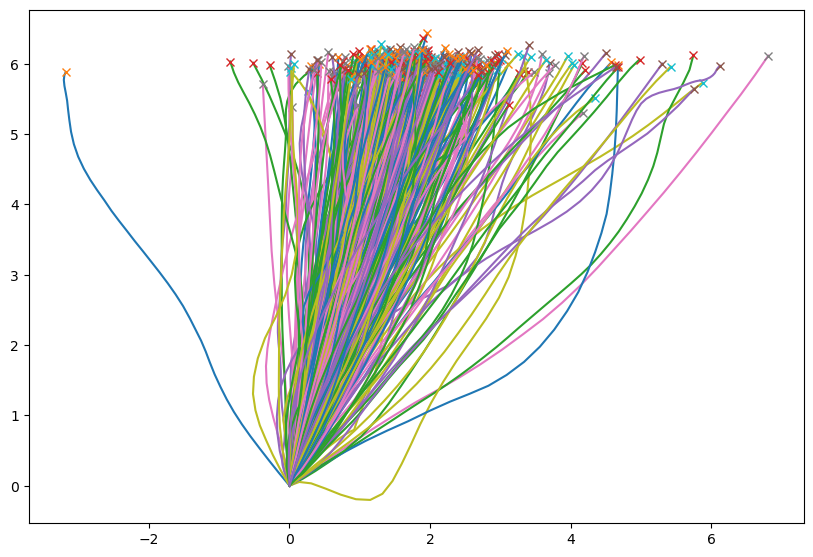

In [12]:
southIds, northDf = indTransformer.convertLocalToNorth(cleanPedDf, tracksMeta)
visualizer.show(northDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

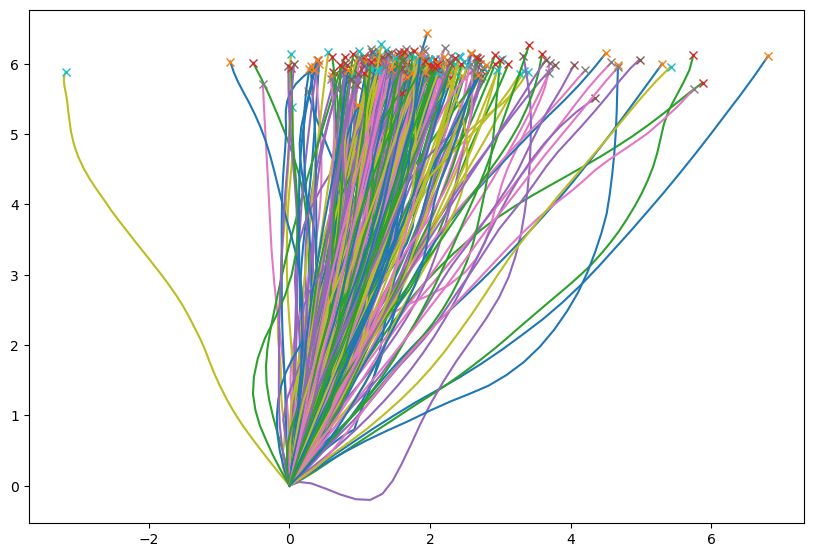

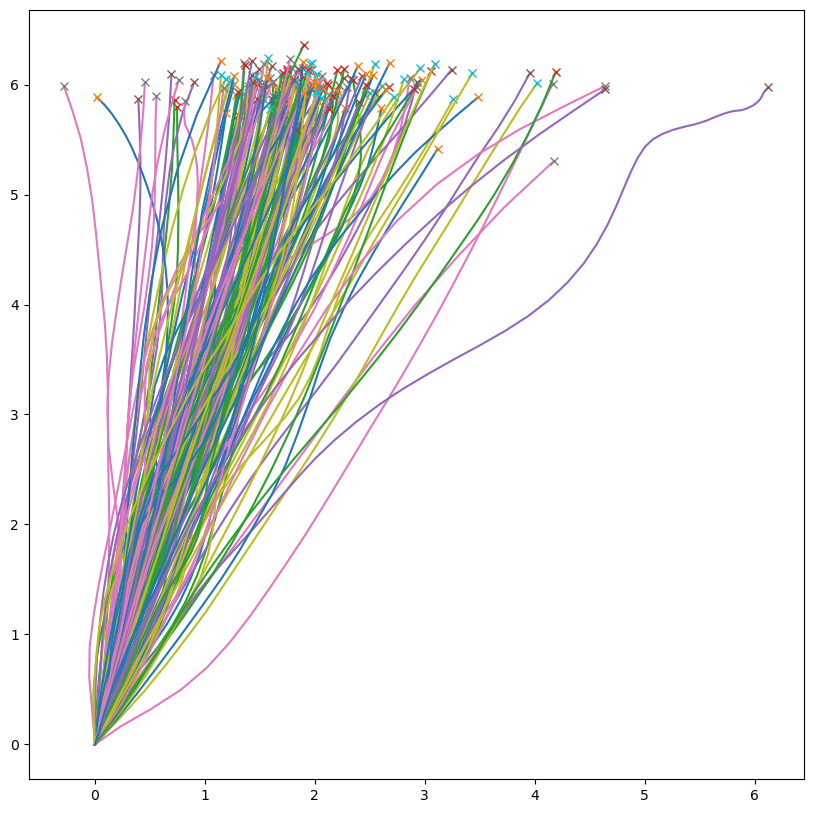

In [13]:
southPeds = northDf[northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(southPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
northPeds = northDf[~northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(northPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### 4. Shape Analysis from Local Source

### Shape dependencies:
1. spline based clustering
2. language based clustering


#### 5.1 Polygon

In [14]:
from tti_dataset_tools import CrosswalkModel
crosswalkModel = CrosswalkModel(colMapper)

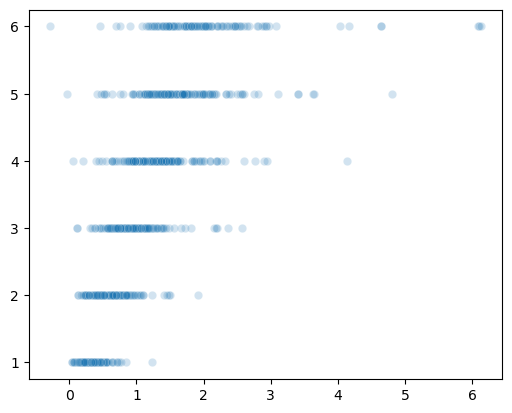

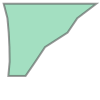

In [15]:
roadWidth = 6.0
interval = 1.0
yTolerance = 0.1

yBreakpoints = list(np.arange(interval, roadWidth, interval))
if (yBreakpoints[-1] - roadWidth) < 0.2:
    yBreakpoints.append(roadWidth)
    
breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
        tracksDf = northPeds,
        yBreakpoints = yBreakpoints,
        yTolerance = yTolerance
    )
visualizer.showBreakpointVals(breakpointXVals)
polygon = crosswalkModel.generatePolygonFromBreakpointVals(breakpointXVals)
polygon

## Single Waypoint Analysis
1. We take the mid waypoint and get slope from origin or distance from the y-axis (both represent the same)
2. We take the slope from the waypoint to the goal.
3. These two variables give the the expressive range 
4. Now we can do a heatmap or we can define a scalar measure? The scalar measure can be fitting a spline with two linear components. nope...

In [16]:
# Some trajectories do not end at 6. Extrapolate?

-0.40317976184996507
-0.01680670813392071
0.06751026158461526
-0.6182083411421975


C:\Users\adhocmaster\AppData\Local\Temp\ipykernel_8164\1805080278.py:32: RuntimeWarning: invalid value encountered in log
  slope2 = np.log((finalY - midY) / (finalX - midX))


,uniqueTrackId,midX,midY,finalX,finalY,slope1,slope2
0,18077,0.827527,3.0,1.286211,5.902285,1.287926,1.844891
1,18078,0.615534,3.0,0.746586,5.793505,1.583877,3.059460
2,18127,1.415526,3.0,2.927649,6.020544,0.751111,0.691922
3,18134,0.915006,3.0,1.619007,5.892554,1.187437,1.413116
4,18147,1.386446,3.0,2.547391,6.190318,0.771868,1.010886


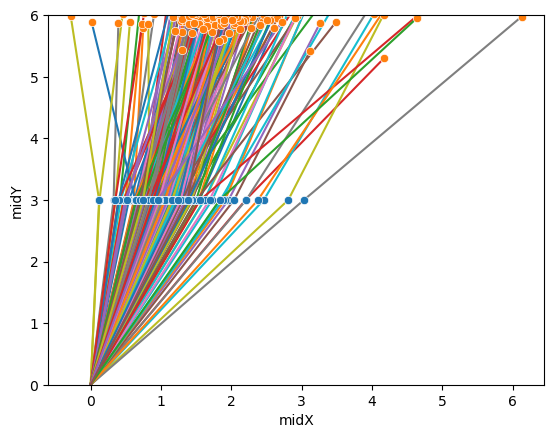

In [26]:
# First we create a new df with ped track id, midx, finalx, finaly, slope1, slope2
midY = 3.0
idCol = "uniqueTrackId"
midYTolerance = 0.5
pedSource= northPeds
pedIds = pedSource[idCol].unique()
rows = []
plot = True
# print(pedSource)
for pedId in pedIds:
    # print(pedId)
    pedDf = pedSource[pedSource[idCol] == pedId]
    # print(pedDf.head())
    candidatesForX = crosswalkModel.getAllLocalXAtLocalYBreakpoint(pedDf, midY, midYTolerance)
    midX = np.mean(candidatesForX)
    if midX < 0:
        midX = min(candidatesForX)
    else:
        midX = max(candidatesForX)
    # print(midX, candidatesForX)
    
    finalX, finalY = pedDf.iloc[-1]["localX"], pedDf.iloc[-1]["localY"]
    
    slope1 = np.log(midY / midX)
    
    finalYDiff = (finalY - midY)
    if finalYDiff < 1:
        print(finalYDiff)
    finalXDiff = (finalX - midX)
    if finalXDiff < 0.1:
        print(finalXDiff)
    slope2 = np.log((finalY - midY) / (finalX - midX))
    # slope2 = (finalY - midY) / (finalX - midX)
        
    rows.append((pedId, midX, midY, finalX, finalY, slope1, slope2))
    if plot:
        plt.plot([0, midX, finalX], [0, midY, finalY], zorder=1)

# print(rows)
    
df = pd.DataFrame(rows, columns=[idCol, "midX", "midY", "finalX", "finalY", "slope1", "slope2"])

if plot:
    sns.scatterplot(df, x="midX", y="midY")
    ax = sns.scatterplot(df, x="finalX", y="finalY", zorder = 2)
    ax.set_ylim(0, 6)

df.head()

In [18]:
df.describe()

,uniqueTrackId,midX,midY,finalX,finalY,slope1,slope2
count,176.000000,176.000000,176.0,176.000000,176.000000,176.000000,173.000000
mean,24042.352273,1.073784,3.0,1.961054,5.984771,1.118202,1.310700
std,3270.672714,0.449308,0.0,0.830521,0.148575,0.454544,0.513447
min,18077.000000,0.119571,3.0,-0.283609,5.303918,-0.010258,-0.038775
25%,22059.250000,0.790780,3.0,1.490551,5.903639,0.846688,0.983123
50%,24013.000000,1.015504,3.0,1.840007,5.995578,1.083248,1.325695
75%,26345.250000,1.286499,3.0,2.230216,6.080543,1.333363,1.571571
max,29530.000000,3.030934,3.0,6.124331,6.361820,3.222459,3.749333


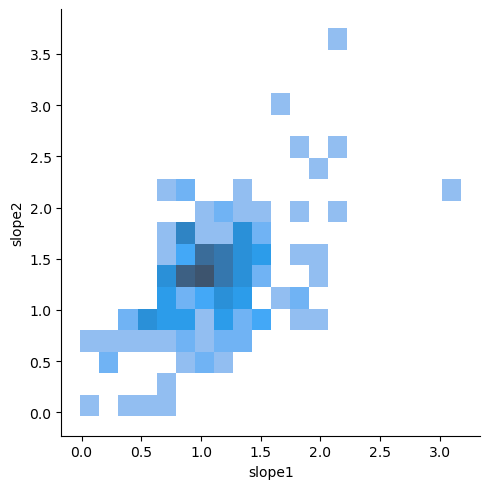

In [19]:
sns.displot(df, x="slope1", y="slope2")

In [33]:
from tti_dataset_tools import RegularKnotsModel
regKnotsModel = RegularKnotsModel(colMapper)

E:\AV\DataSetExploration\TTI-dataset-tools\src\tti_dataset_tools\patterns\RegularKnotsModel.py:64: RuntimeWarning: invalid value encountered in log
  slope2 = np.log((finalY - midY) / (finalX - midX))


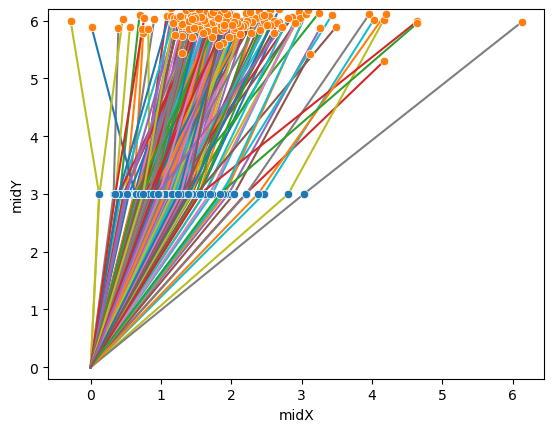

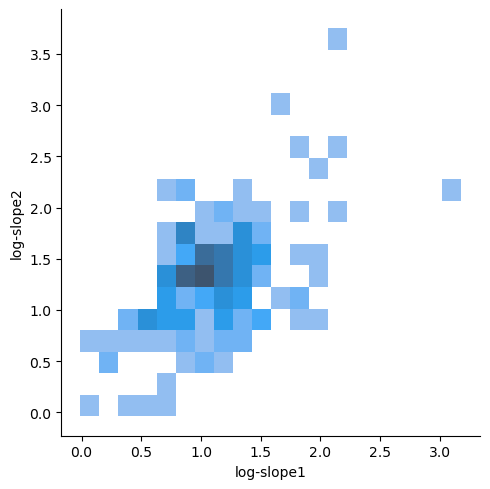

In [44]:
knotDf = regKnotsModel.getSingleKnotData(northPeds, midY=3.0, midYTolerance=0.5, plot=True)

E:\AV\DataSetExploration\TTI-dataset-tools\src\tti_dataset_tools\patterns\RegularKnotsModel.py:125: RuntimeWarning: invalid value encountered in log
  slope = np.log(yDiff / xDiff)


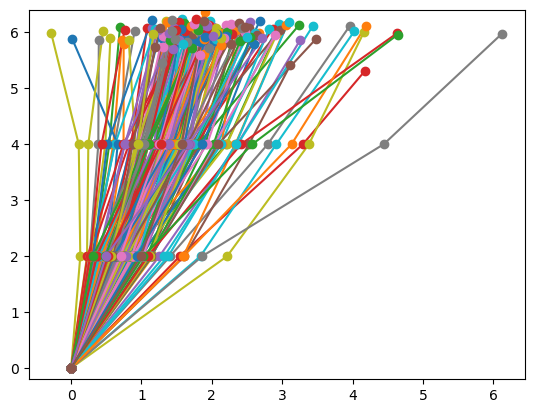

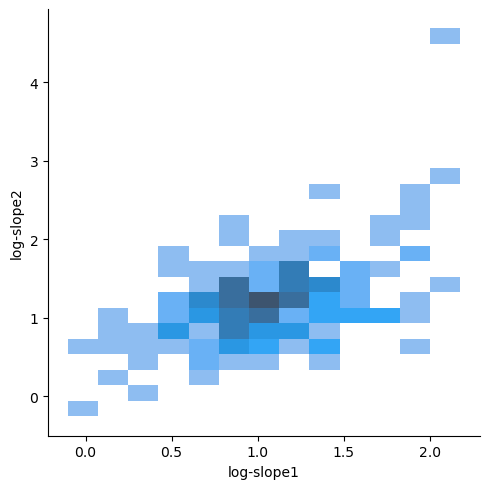

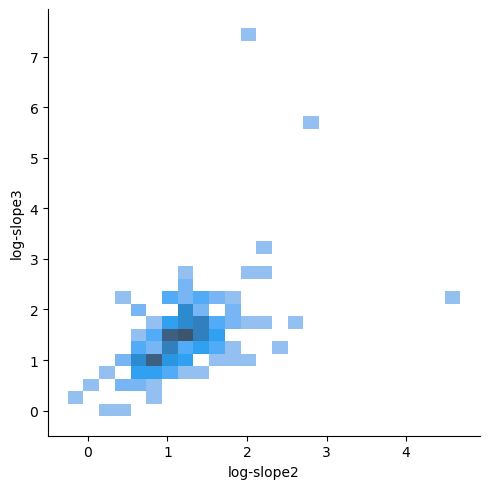

In [49]:
knotDf = regKnotsModel.getKnotData(northPeds, yBreakpoints=[2.0, 4.0], yTolerance=0.5, plot=True)

In [35]:
knotDf

,uniqueTrackId,x0,y0,log-slope0,x1,y1,log-slope1,x2,y2,log-slope2
0,18077,0.604711,2.0,1.196151,1.062111,4.0,1.475345,1.286211,5.902285,2.138718
1,18078,0.487089,2.0,1.412456,0.745649,4.0,2.045776,0.746586,5.793505,7.556866
2,18127,0.828807,2.0,0.880916,2.206268,4.0,0.372905,2.927649,6.020544,1.029954
3,18134,0.566293,2.0,1.261791,1.181882,4.0,1.178324,1.619007,5.892554,1.465462
4,18147,0.861562,2.0,0.842155,1.871849,4.0,0.682913,2.547391,6.190318,1.176287
...,...,...,...,...,...,...,...,...,...,...
171,29342,1.600510,2.0,0.222825,3.133324,4.0,0.266042,4.190296,6.115723,0.693988
172,29431,1.025922,2.0,0.667555,2.575871,4.0,0.254925,4.642903,5.958908,-0.053727
173,29442,0.523376,2.0,1.340602,1.272349,4.0,0.982199,1.774771,6.235637,1.492842
174,29472,0.495053,2.0,1.396239,1.665238,4.0,0.535985,2.718074,5.889830,0.585000
